In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports:

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-02-14 13:52:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-14 13:52:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-14 13:52:09--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [3]:
!pip install sweetviz
import sweetviz as sv
import pandas as pd
import operator 
from collections import Counter
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import tensorflow as tf
import tensorflow.keras as keras
from wordcloud import WordCloud
import seaborn as sns
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import TweetTokenizer
import operator 
import json

sns.set_style('darkgrid')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Question 1:**

In [4]:
DATA_PATH = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(DATA_PATH, encoding = "ISO-8859-1", header=None)

In [5]:
df.columns = ['target','id','date','flag','user','text']
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#Understanding the data:

                                             |          | [  0%]   00:00 -> (? left)


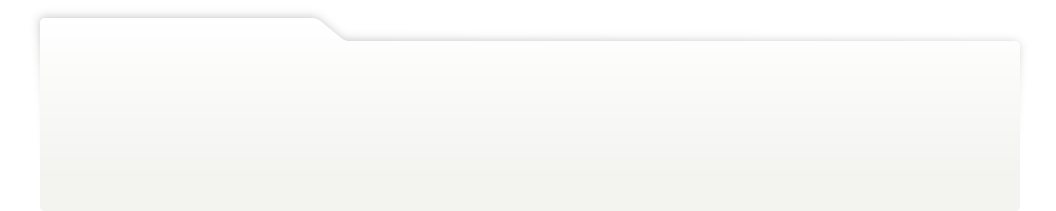
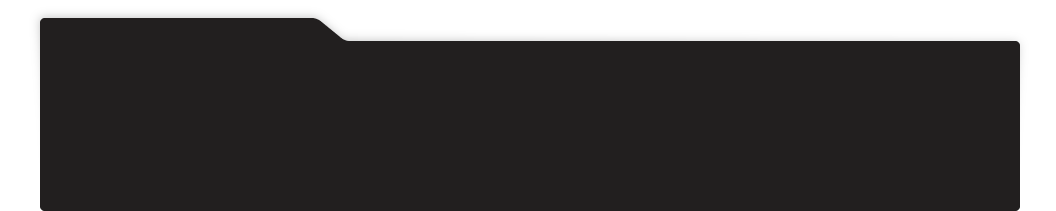
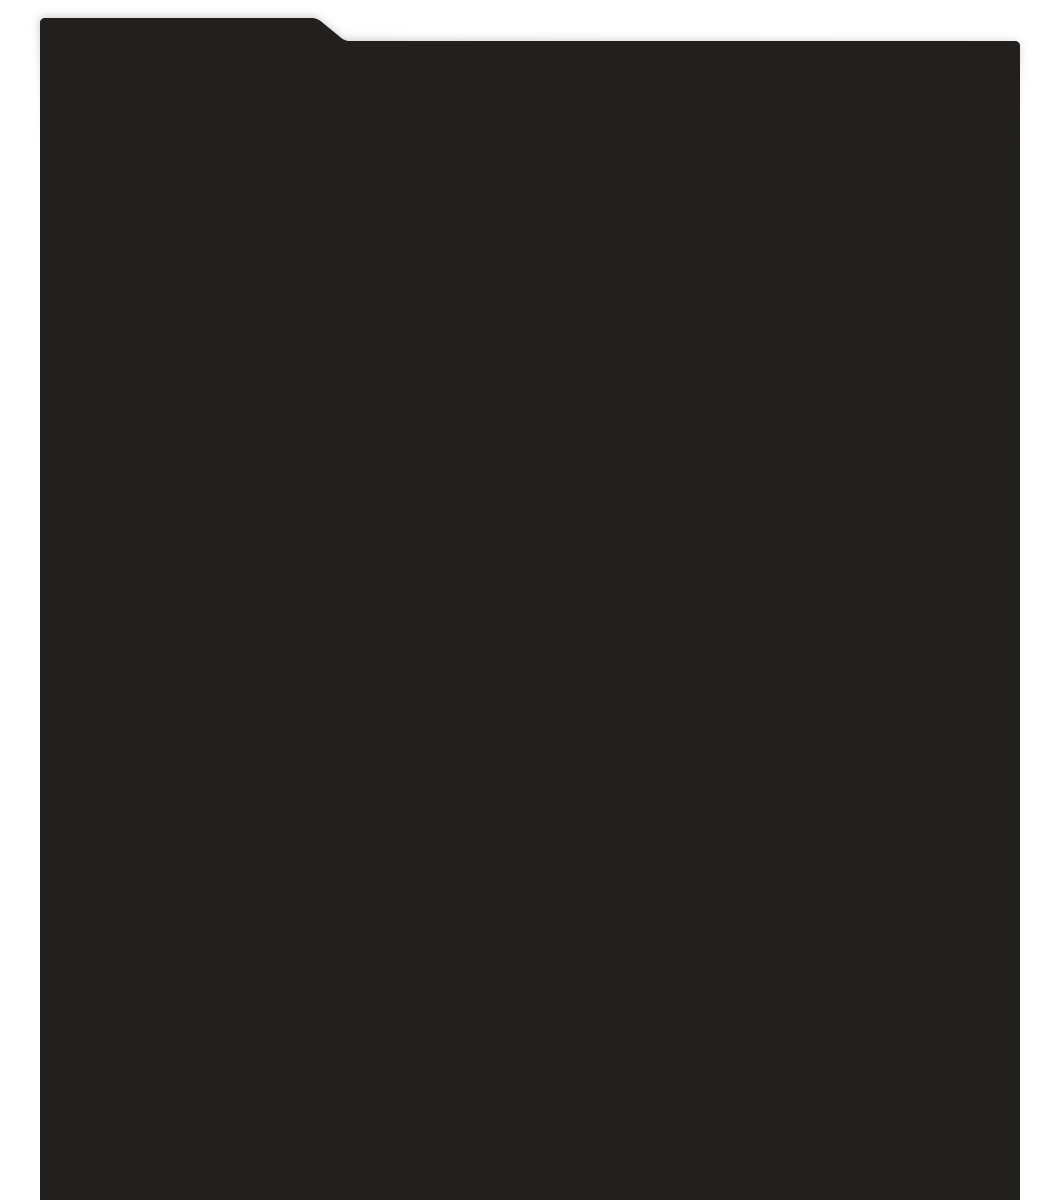
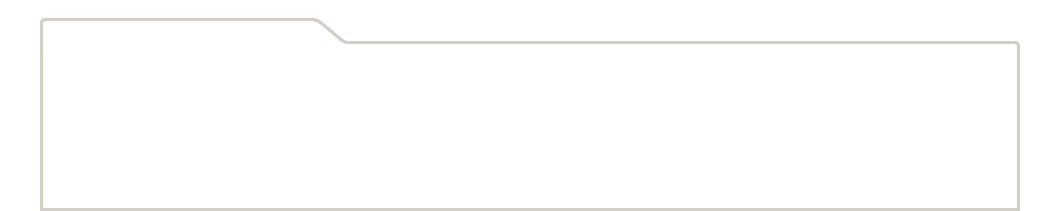
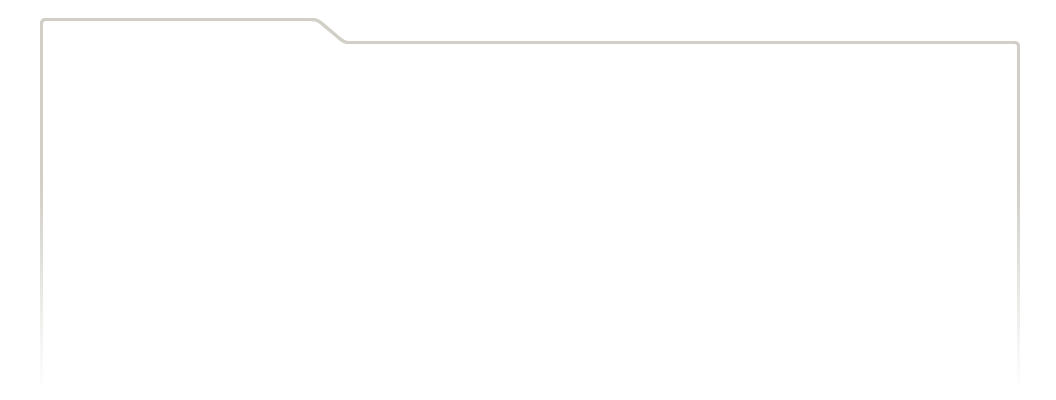
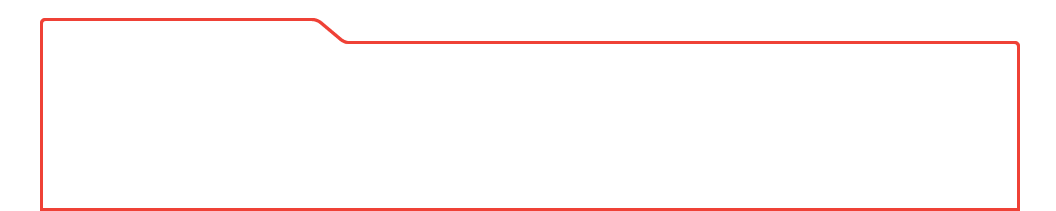
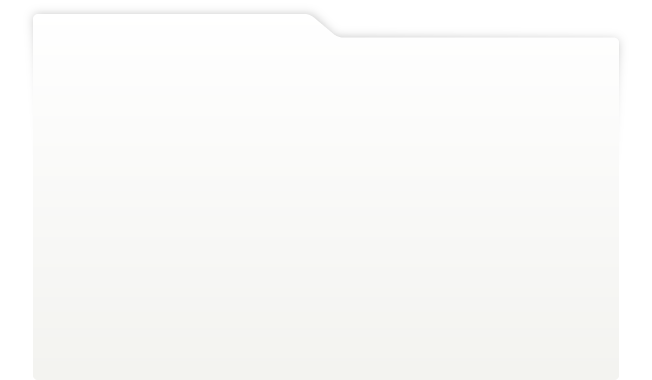
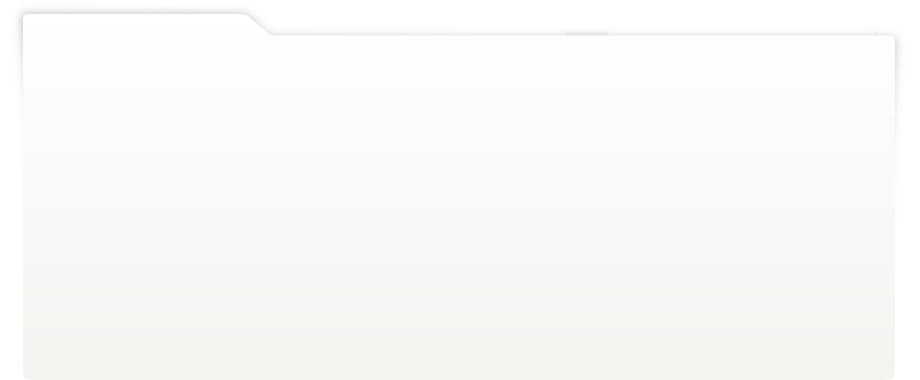
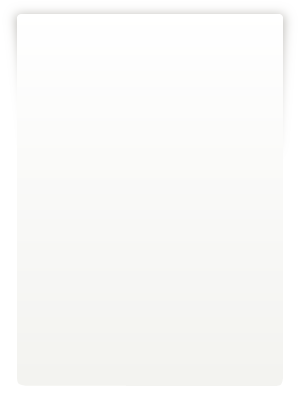
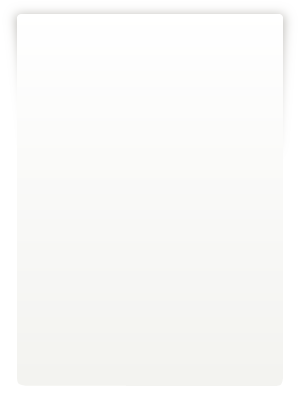
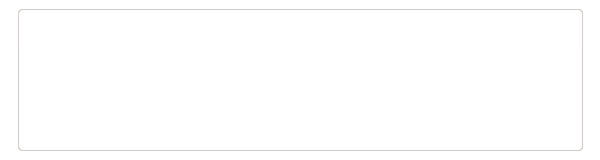
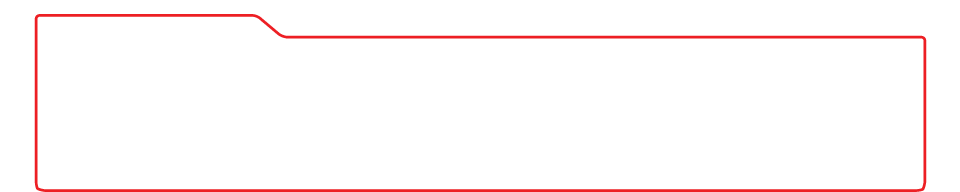
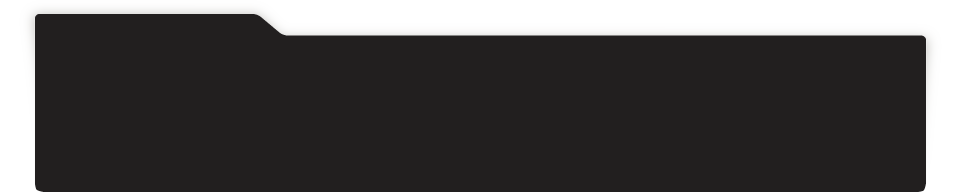
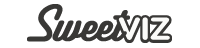
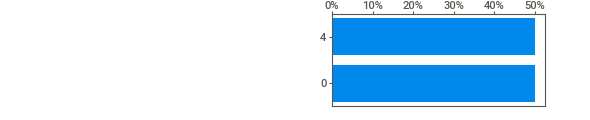
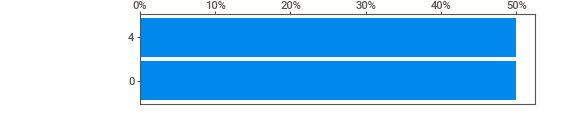
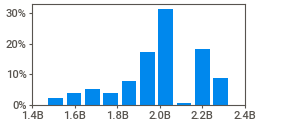
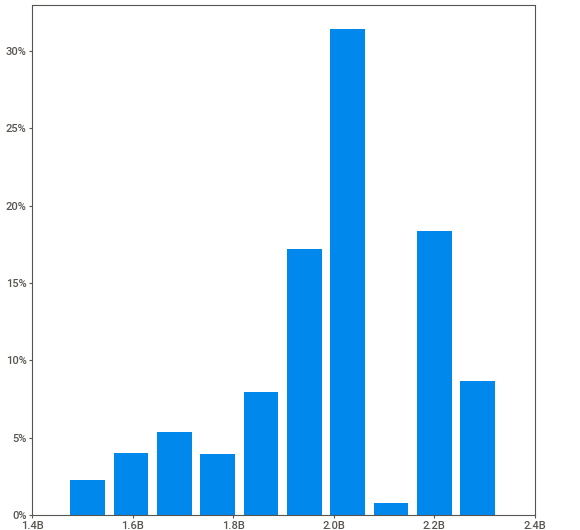
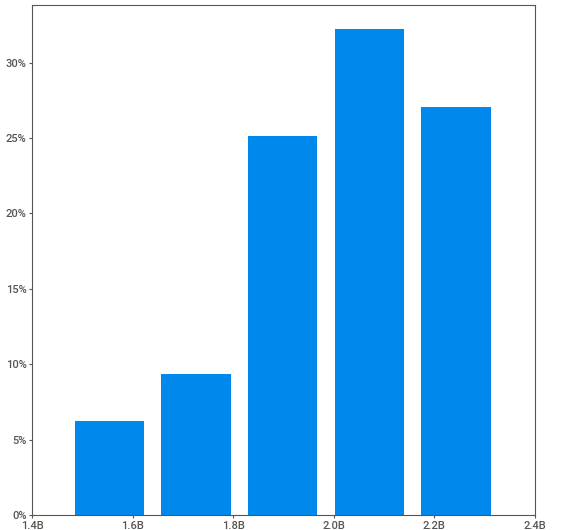
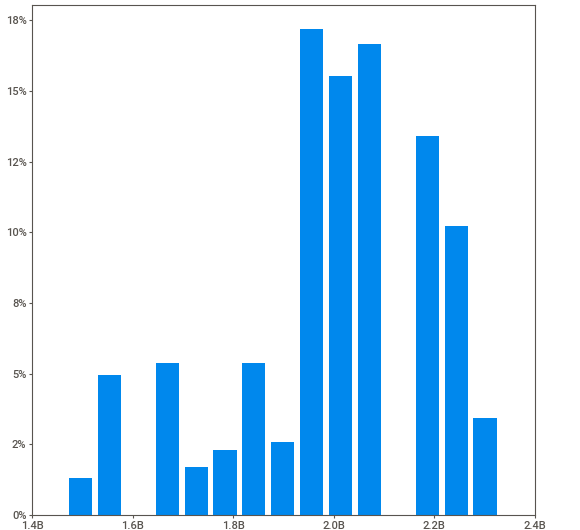
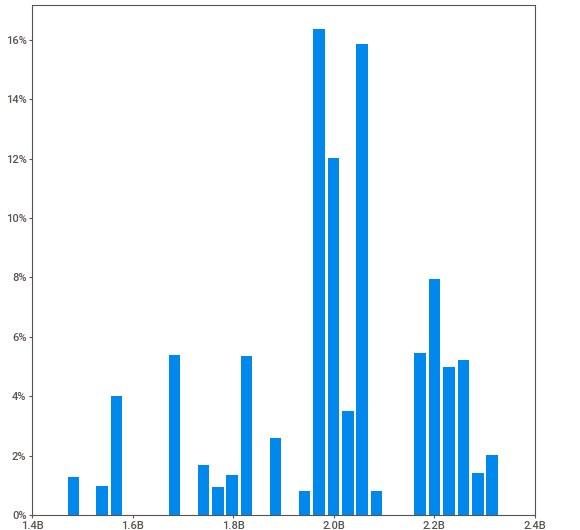
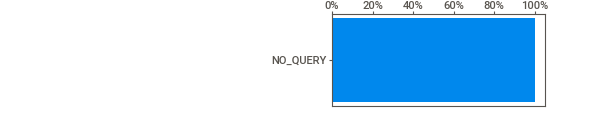
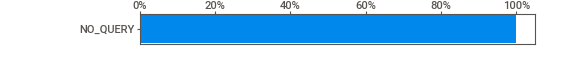
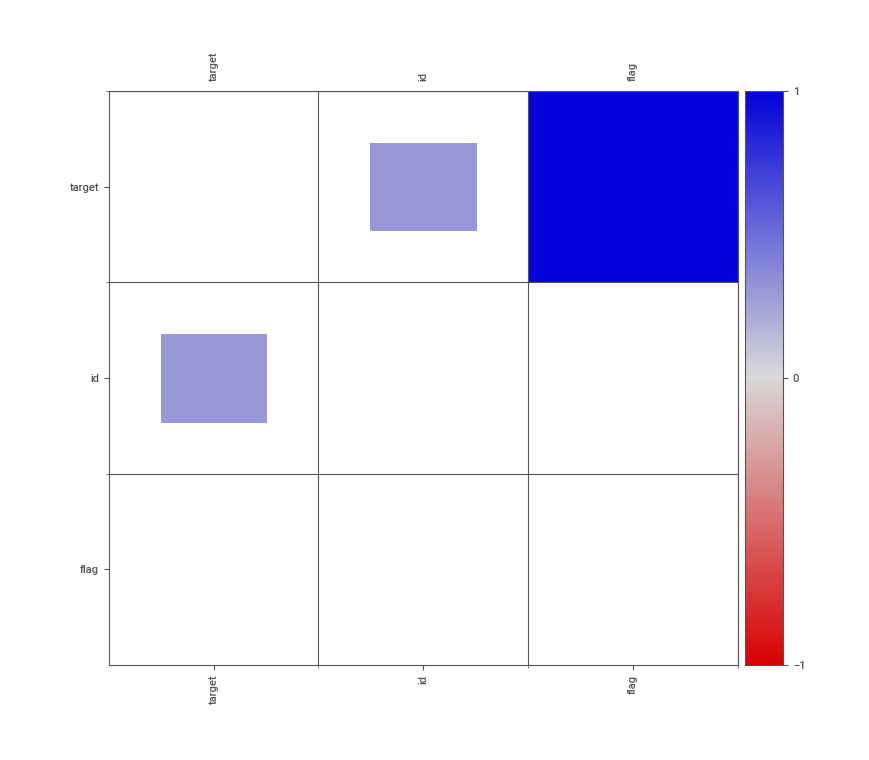
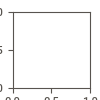

In [6]:
#analyzing the dataset
advert_report = sv.analyze(df)
#display the report
advert_report.show_notebook()

In [7]:
df = df.drop(columns=['flag','id','date','user'])
# Change label '4' to '1'
df.target = df.target.map({4:1,0:0})
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


Get 100000 records from the dataset balanced by the target value

In [8]:
neg = df[df.target == 0][0:50000]
pos = df[df.target == 1][80000:130000]
print(str(len(pos)+len(neg)))

100000


In [9]:
# get the fina data set
frames = [neg, pos]
df = pd.concat(frames)
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
929995,1,@Hoodtip101 hii im ur biggest fan hood tip i l...
929996,1,@turtledip I miss u guys too
929997,1,I have to laugh. The kids sure are more willin...
929998,1,@lovebscott enjoying some pasta from pizza hut...


#Preprocessing:

In [10]:
tweet_tokenizer= TweetTokenizer(reduce_len=3)
df.text = df.text.apply(lambda x: tweet_tokenizer.tokenize(x))

In [11]:
def remove(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('http[s]?://\S+|www\.\S+', '', text)
    text = re.sub('<[^>]+>', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via', 'the',u'\u2019',u'\u2026','The',u'de',u'\xe9']
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    # r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    #return tokens_re.findall(s.encode('ascii','replace'))
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=True):
    s=remove(s)
    tokens = tokenize(s)
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    tokens=[w for w in tokens if not w in stop]
    return tokens

In [12]:
# Function for build text list
def word_list(dataframe,clear_stopwords=False):
  df = dataframe.copy()
    
  # lemmatize the word
  lemma = nltk.WordNetLemmatizer()
  df.text = df.text.apply(lambda x: [lemma.lemmatize(i) for i in x])
  if clear_stopwords:
    stop_words = stopwords.words('english')
    df.text = df.text.apply(lambda x: [i for i in x if not i in stop_words])
    
  # combined into a sentence again
  df.text = df.text.apply(lambda x: ' '.join(x))

  word_list = df.text.tolist()
  return word_list

# Tokenize and padding the text list
def token_padding(word_list, tokenizer,length,pad):
  sequences = tokenizer.texts_to_sequences(word_list)
  padding = pad_sequences(sequences, maxlen=length,padding=pad,truncating='post')
  return padding

In [13]:
df['text']=df['text'].apply(lambda X: " ".join(X))
df['text']=df['text'].apply(preprocess)
df

,target,text
0,0,"[switchfoot, awww, bummer, shoulda, got, david..."
1,0,"[upset, update, facebook, texting, might, cry,..."
2,0,"[kenichan, dived, many, times, ball, managed, ..."
3,0,"[whole, body, feels, itchy, like, fire]"
4,0,"[nationwideclass, behaving, mad, see]"
...,...,...
929995,1,"[hii, im, ur, biggest, fan, hood, tip, love, l..."
929996,1,"[turtledip, miss, u, guys]"
929997,1,"[laugh, kids, sure, willing, give, dad, back, ..."
929998,1,"[lovebscott, enjoying, pasta, pizza, hut, watc..."


#Data Visualization:

Show the graph distribution for each target value:

In [14]:
def count_class(num_class):
  count = Counter()
  for tweet in df['text'][df.target == num_class]:
        # Create a list with all the terms
        #terms_all = [term for term in preprocess(tweet['text'],True) if term not in stop and  term.startswith(('#'))]
        terms_all = [term for term in tweet if term not in stop]
        # Update the counter
        count.update(terms_all)
  return count

# Print the first 10 most frequent words
count_pos=count_class(1)
count_neg=count_class(0)
print("10 most common words in the negative tweets:")
print(count_neg.most_common(10))
print("10 most common words in the positive tweets:")
print(count_pos.most_common(10))

10 most common words in the negative tweets:
[('work', 3499), ('go', 3071), ('get', 2821), ('day', 2728), ('back', 2653), ('today', 2591), ('like', 2417), ('going', 2207), ('got', 2134), ('still', 1903)]
10 most common words in the positive tweets:
[('day', 5691), ('good', 3871), ('happy', 3415), ('love', 3076), ('like', 2303), ('lol', 2213), ('thanks', 2130), ('get', 2021), ('u', 1922), ('today', 1891)]


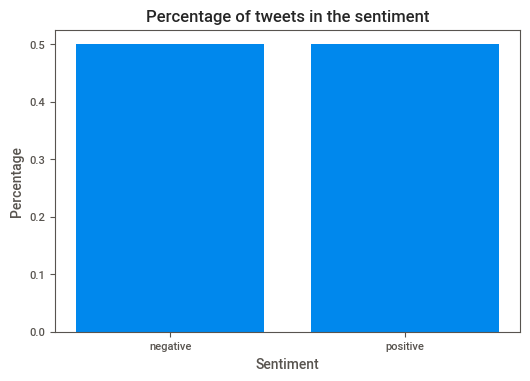

In [15]:
# x axis values for the days in the week
x = ["negative","positive"] 
# corresponding y axis values 
y = [len(df.loc[df['target'] == 0])/len(df),len(df.loc[df['target'] == 1])/len(df)] 
plt.bar(x, y) 
plt.xlabel('Sentiment') 
plt.ylabel('Percentage') 
plt.title('Percentage of tweets in the sentiment')
plt.show() 

#Modeling:

**Question 2:**

Split to train and test sets:

In [16]:
# tokenize and padding
embedding_dim = 50 # since we will use 50d of Glove
max_length = 30
padding = 'post'
oov_tok = '<OOV>'
batch_size = 256
training_size = 80000
test_size = 20000 #number of samples for testing, not percentage
stop_words_clear = False

# cropped_df = df.sample(training_size) #get the sample randomly from the original dataset

# Split the data into training and validation(test) set
x_train,x_val,y_train,y_val = train_test_split(df.drop('target',axis=1),df['target'],test_size=0.2)
x_train_list = word_list(x_train,clear_stopwords=stop_words_clear)
x_val_list = word_list(x_val,clear_stopwords=stop_words_clear)

# make tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_list)

x_train_pad = token_padding(x_train_list,tokenizer,max_length,padding)
x_val_pad = token_padding(x_val_list,tokenizer,max_length,padding)

train_set = tf.data.Dataset.from_tensor_slices((x_train_pad,np.array(y_train))).batch(batch_size)
test_set = tf.data.Dataset.from_tensor_slices((x_val_pad,np.array(y_val))).batch(batch_size)

Create the Embedding Matrix:

In [17]:
word_index = tokenizer.word_index
vocab_size = len(word_index)+1
embeddings_index = {};

# Word embeddings with Glove6B 50D
# Add the glove6b 50D to the input data of kaggle before use it
with  open('glove.6B.50d.txt','r', encoding="utf8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
        
# Build embedding matrix 
embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embeddings_matrix[i] = vector

Build the Deep learning Model:

In [18]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=()):
    train_loss = logs.get('loss')
    val_loss = logs.get('val_loss')
    if val_loss - train_loss > 0.2:
      print('Loss on validation set is much higher than training set. Training cancelled')
      self.model.stop_training=True


def build_model(vocab_size,embedding_dim,max_length):
  model = keras.models.Sequential([
          Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length,
                   weights=[embeddings_matrix],
                   trainable=False),
          Bidirectional(LSTM(64,dropout=0.3,return_sequences=True)),
          Dropout(0.3),
          Bidirectional(LSTM(64,dropout=0.3)),
          Dropout(0.3),
          Dense(512,activation='relu'),
          Dropout(0.3),
          Dense(1,activation='sigmoid')])
      
  model.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['acc'])
  return model

In [19]:
num_epochs = 20
callbacks = myCallback()
model = build_model(vocab_size,embedding_dim,max_length)

# start training
history = model.fit(train_set,epochs=num_epochs,validation_data=(test_set),verbose=1,callbacks=[callbacks])

Epoch 1/20
313/313 [==============================] - 129s 392ms/step - loss: 0.6258 - acc: 0.6480 - val_loss: 0.5646 - val_acc: 0.7029
Epoch 2/20
313/313 [==============================] - 120s 383ms/step - loss: 0.5714 - acc: 0.6949 - val_loss: 0.5428 - val_acc: 0.7189
Epoch 3/20
313/313 [==============================] - 117s 375ms/step - loss: 0.5531 - acc: 0.7120 - val_loss: 0.5309 - val_acc: 0.7278
Epoch 4/20
313/313 [==============================] - 117s 374ms/step - loss: 0.5410 - acc: 0.7211 - val_loss: 0.5238 - val_acc: 0.7326
Epoch 5/20
313/313 [==============================] - 118s 376ms/step - loss: 0.5348 - acc: 0.7239 - val_loss: 0.5186 - val_acc: 0.7370
Epoch 6/20
313/313 [==============================] - 124s 395ms/step - loss: 0.5287 - acc: 0.7302 - val_loss: 0.5162 - val_acc: 0.7370
Epoch 7/20
313/313 [==============================] - 118s 376ms/step - loss: 0.5239 - acc: 0.7299 - val_loss: 0.5132 - val_acc: 0.7395
Epoch 8/20
313/313 [============================

In [20]:
# Final evaluation of the model
scores = model.evaluate(train_set, verbose=0)
print("Deep learning Accuracy on train: %.2f%%" % (scores[1]*100))
scores = model.evaluate(test_set, verbose=0)
print("Deep learning Accuracy on test: %.2f%%" % (scores[1]*100))

Deep learning Accuracy on train: 78.89%
Deep learning Accuracy on test: 75.70%


SVM:

In [21]:
X_train= x_train['text'].apply(lambda x: " ".join(x))
X_test= x_val['text'].apply(lambda x: " ".join(x))
y_test = y_val

In [49]:
#features exraction method - TF-IDF + NGRAM=3
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
x_train_tfidf = vectorizer.fit_transform(X_train)
x_test_tfidf = vectorizer.transform(X_test)


In [53]:
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(alpha=0.0001,max_iter=1500)
svm.fit(x_train_tfidf, y_train)
#accuracy on train 
y_pred_svm = svm.predict(x_train_tfidf)
print(f"SVM Accuracy on train set:")
print(classification_report(y_train, y_pred_svm, labels=[0, 1])) 
#accuracy on test
y_pred_svm = svm.predict(x_test_tfidf)
print(f"SVM Accuracy on test set:")
print(classification_report(y_val, y_pred_svm, labels=[0, 1])) 

SVM Accuracy on train set:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83     40013
           1       0.83      0.84      0.83     39987

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000

SVM Accuracy on test set:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      9987
           1       0.76      0.75      0.76     10013

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



#Tweeter API:

**Question 3:**

Get data from twitter:

In [24]:
import tweepy
from tweepy import OAuthHandler

#keys
consumer_key = 'rG88hwo8mA2jRbpAOloIuLJoD'
consumer_secret = 'ejBhVSIH4qw83IyKgpG4s1QujBNCDXqJq4vUUT9RTmFnLTNRaR'
access_token = '1349402376592117764-RYuR6d8sPRutYClxe93udiTiNK0VmS'
access_secret = '2np9HnFKcYrs1kY1EG3crSF7LGFO1VPErmnLgct3VTOJM'

auth = OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)

api = tweepy.API(auth)

Excecute this code for an hour for 7 days at the same time:

In [25]:
# f = open("covid7.json", "x")

# import tweepy
# class MyStreamListener(tweepy.StreamListener):
#   def on_data(self, data):
#         try:
#             with open('covid7.json', 'a') as f:
#                 f.write(data)
#                 return True
#         except BaseException as e:
#             print("Error on_data: %s" % str(e))
#         return True
  
#   def on_error(self, status):
#         print(status)
#         return True

# myStreamListener = MyStreamListener()
# myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
# myStream.filter(track=['Covid-19'],languages=['en'])
# #run every day. stop after a few minutes.

Read the json file and put only the text into a list:

In [26]:
def get_data_from_path(path):
  tweets_from_file = []
  with open(path, 'r',encoding="utf-8") as f:
      for line in f:
          if len(line) < 10:
              continue
          tweet = json.loads(line)
          # Create a list with all the terms
          tweets_from_file.append(tweet['text'])
  return tweets_from_file

Union the lists of the all days to a DataFrame:

In [27]:
text_table1 = get_data_from_path('/content/drive/MyDrive/covid1.json')
tweet_data1 = pd.DataFrame(text_table1,columns=['text'])
tweet_data1["day"]=1

text_table2 = get_data_from_path('/content/drive/MyDrive/covid2.json')
tweet_data2 = pd.DataFrame(text_table2,columns=['text'])
tweet_data2["day"]=2

text_table3 = get_data_from_path('/content/drive/MyDrive/covid3.json')
tweet_data3 = pd.DataFrame(text_table3,columns=['text'])
tweet_data3["day"]=3

text_table4 = get_data_from_path('/content/drive/MyDrive/covid4.json')
tweet_data4 = pd.DataFrame(text_table4,columns=['text'])
tweet_data4["day"]=4

text_table5 = get_data_from_path('/content/drive/MyDrive/covid5.json')
tweet_data5 = pd.DataFrame(text_table5,columns=['text'])
tweet_data5["day"]=5

text_table6 = get_data_from_path('/content/drive/MyDrive/covid6.json')
tweet_data6 = pd.DataFrame(text_table6,columns=['text'])
tweet_data6["day"]=6

text_table7 = get_data_from_path('/content/drive/MyDrive/covid7.json')
tweet_data7 = pd.DataFrame(text_table7,columns=['text'])
tweet_data7["day"]=7

frames = [tweet_data1, tweet_data2,tweet_data3,tweet_data4,tweet_data5,tweet_data6,tweet_data7]
tweet_data = pd.concat(frames)
#remove duplicates
tweet_data=tweet_data.drop_duplicates(subset=['text'])

Preprocess the data from twiter:

In [28]:
tweet_tokenizer= TweetTokenizer(reduce_len=3)
tweet_data.text = tweet_data.text.apply(lambda x: tweet_tokenizer.tokenize(x))
tweet_data

,text,day
0,"[RT, @AP_Africa, :, Malawi, faces, a, resurgen...",1
1,"[@SenSchumer, Thank, you, ..., please, ignore,...",1
2,"[RT, @simonallison, :, It, was, tweeting, abou...",1
3,"[Good, thread, on, COvid, exposing, existing, ...",1
4,"[Missouri, lawmaker, indicted, for, allegedly,...",1
...,...,...
8964,"["", China, :, Covid, -, 19, is, Back, -, ARTE,...",7
8965,"[“, Disabled, students, are, a, segment, of, t...",7
8966,"[We, are, dispensable, to, the, Torys, !, !]",7
8967,"[Ocado, sales, surge, as, home, deliveries, ri...",7


Create lists Positive and Negative terms to our labeling:

In [29]:
tweet_data['text']=tweet_data['text'].apply(lambda X: " ".join(X))
tweet_data['text']=tweet_data['text'].apply(preprocess)
tweet_data

,text,day
0,"[apafrica, malawi, faces, resurgence, covid, o...",1
1,"[senschumer, thank, please, ignore, gop, notic...",1
2,"[simonallison, tweeting, story, got, account, ...",1
3,"[good, thread, covid, exposing, existing, soci...",1
4,"[missouri, lawmaker, indicted, allegedly, sell...",1
...,...,...
8964,"[china, covid, back, arte, reportage, watch, f...",7
8965,"[disabled, students, segment, academic, commun...",7
8966,"[dispensable, torys]",7
8967,"[ocado, sales, surge, home, deliveries, rise, ...",7


In [30]:
positive_terms={'thanks','lol','like','love','happy','good','adorable','amazing','accomplishment','adventure','admire','affirmative','agreeable','appealing','attractive',
                'beaming','beneficial','bounty','brilliant','beautiful','bliss','brave','bubbly','believe','bountiful',
                'calm','champ','cheery','classical','composed','cool','cute','celebrated','champion','clean','congratulation','courageous','charming','classic','creative',
                'dazzling','delight','divine','delightful',
                'exciting','esteemed','engaging','endorsed','elegant','efficient','ecstatic','excellent','essential','energized','encouraging','electrifying','effervescent','easy','exquisite','enthusiastic','energetic','effortless','effective','earnest',
                'fun','free','fitting','favorable','familiar','friendly','fortunate','fine','fantastic','fair','funny','fresh','flourishing','fetching','famous','fabulous',
                'grin','graceful','glowing','genuine','gorgeous','glamorous','genius','growing','great','good','generous',
                'honorable','hearty','harmonious','hug','honest','healthy','happy','honored','heavenly','healing','handsome',
                'inventive','intellectual','instant','independent','imaginative','intuitive','instinctive','innovative','impressive','ideal','intelligent','instantaneous','innovate',
                'jubilant','joy','jovial',
                'kind','knowledgeable','keen',
                'luminous','lovely','legendary','lucky','lively','lucid','light','laugh',
                'miraculous','meaningful','meritorious','masterful','motivating','merit','marvelous',
                'nutritious','novel','nurturing','nice',
                'optimistic','okay',
                'protected','productive','prepared','popular','plentiful','phenomenal','prominent','principled','powerful','polished','pleasurable','perfect','proud','progress','pretty','positive','poised','pleasant','paradise',
                'quiet', 'quick', 'quality', 'robust', 'right', 'rewarding', 'reward', 'restored', 'respected', 'resounding', 'remarkable', 'reliable', 'rejoice', 'refreshing', 'refined', 'reassuring',
                'ready', 'surprising', 'supporting', 'superb', 'super', 'sunny', 'successful', 'success', 'stupendous', 'stunning', 'stirring', 'spiritual', 'spirited', 'special', 'sparkling', 'soulful', 'smile', 'skillful', 'skilled', 'simple', 'satisfactory', 'seemly', 'safe', 'secure',
                'trusting', 'tranquil', 'thrilling', 'transforming', 'tops', 'thorough', 'terrific', 'thriving', 'transformative', 'truthful', 'unreal', 'upbeat', 'unwavering', 'upright', 'up', 'upstanding', 'vivacious', 'vigorous', 'virtuous', 'vital', 'victory', 'vibrant', 'valued',
                'zeal', 'well', 'worthy', 'willing', 'wondrous', 'wholesome', 'welcome', 'wealthy', 'whole,' 'wonderful', 'wow', 'yes'}
negative_terms={
    'atrocious','anxious','alarming','appalling','annoy','adverse','awful','apathy','angry','abysmal',
    'beneath','barbed','broken','bemoan','banal','boring','belligerent','bad',
    'cutting','criminal','corrupt','contradictory','clumsy','cry','creepy','corrosive','confused',"can't",'cruel','crazy','contrary','collapse','coarse','callous',
    "don't",'dishonorable','disgusting','detrimental','depressed','deformed','dastardly','dreary','distress','dishonest','disease','despicable','deplorable','decaying','damaging','dreadful','dismal','disheveled','dirty','deprived','deny','dead','damage',
    'evil','eroding','enraged',
    'frightful','filthy','fear','frighten','fight','faulty','foul','feeble','fail',
    'gruesome','grimace','grave','grotesque','grim','ghastly','guilty','gross','greed','gawky',
    'hurtful','horrible','hideous','hurt','horrendous','hate','hard','hostile','harmful','haggard',
    'insipid','injurious','inelegant','imperfect','ignore','insidious','injure','inane','immature','ignorant','insane','infernal','impossible','ill','icky',
    'lumpy','lousy','lose','junky','jealous',
    'moldy','missing','menacing','moan','misshapen','mean','monstrous','misunderstood','messy','malicious',
    'noxious', 'not', 'nonsense', 'nondescript', 'no', 'negative', 'negate', 'naughty', 'nasty', 'naive',
    'oppressive', 'offensive', 'odious', 'objectionable', 'prejudice', 'poor', 'poisonous', 'plain', 'petty', 'pessimistic', 'perturb', 'pain',
    'quit', 'quirky', 'questionable', 'ruthless', 'rude', 'rotten', 'rocky', 'revolting', 'revenge', 'repulsive', 'repugnant', 'repellant', 'renege', 'reject',
    'suspicious', 'suspect', 'substandard', 'stupid', 'stuck', 'stressful', 'stormy', 'stinky', 'sticky', 'spiteful', 'sorry', 'sobbing', 'smelly', 'slimy', 'sinister', 'sickening', 'sick', 'shoddy', 'shocking', 'severe', 'scream', 'scary', 'savage', 'scare', 'sad',
    'wound', 'worthless', 'woeful', 'weary', 'yucky', 'yell', 'zero', 'vindictive', 'villainous', 'vile', 'vicious', 'vice',
    'threatening', 'terrifying', 'terrible', 'tense', 'upset', 'unwise', 'unwieldy', 'unwholesome', 'unwelcome', 'unwanted', 'untoward', 'unsightly', 'unsatisfactory', 'unpleasant', 'unlucky', 'unjust', 'unhealthy', 'unhappy', 'unfavorable', 'unfair', 'undermine', 'ugly'
}

In [31]:
#create empty columns in the dataframe
tweet_data["label"] = -1

def get_label(row):
  label=np.nan
  num_pos=0
  num_neg=0
  for term in row:
    if term in positive_terms:
      num_pos+=1
    elif term in negative_terms:
      num_neg+=1

  if num_pos > num_neg and num_pos/len(row)>0.3:
    return 1
  elif num_pos < num_neg and num_neg/len(row)>0.3:
    return 0
  else: return -1

In [32]:
tweet_data["label"]=tweet_data["text"].apply(get_label)

In [33]:
print(f"num of natural tweets {len(tweet_data.loc[tweet_data['label'] == -1])} ")
print(f"num of negative tweets {len(tweet_data.loc[tweet_data['label'] == 0])}")
print(f"num of positive tweets {len(tweet_data.loc[tweet_data['label'] == 1])}")

num of natural tweets 31373 
num of negative tweets 59
num of positive tweets 225


In [34]:
def count_class_tweets(num_class):
  count = Counter()
  for tweet in tweet_data['text'][tweet_data.label == num_class]:
        terms_all = [term for term in tweet if term not in stop]
        # Update the counter
        count.update(terms_all)
  return count

# Print the first 10 most frequent words
count_pos_tweets=count_class_tweets(1)
count_neg_tweets=count_class_tweets(0)
print("10 most common words in the negative tweets:")
print(count_neg_tweets.most_common(10))
print("10 most common words in the positive tweets:")
print(count_pos_tweets.most_common(10))

10 most common words in the negative tweets:
[('sad', 10), ('poor', 5), ('awful', 4), ('covid', 4), ('fight', 3), ('mean', 3), ('stupid', 3), ('crazy', 3), ('fuck', 2), ('must', 2)]
10 most common words in the positive tweets:
[('good', 44), ('well', 32), ('great', 24), ('news', 23), ('covid', 19), ('like', 16), ('love', 12), ('thanks', 12), ('safe', 12), ('right', 12)]


**Question 4:**

Create the test set: 

In [35]:
x_tweet_test= tweet_data['text'].apply(lambda x: " ".join(x))
x_tweet_test_tfidf = vectorizer.transform(x_tweet_test)

As the best classifier is the SVM model, we will use it for the collected data:

In [54]:
tweet_data["SVM predictions"]= svm.predict(x_tweet_test_tfidf)

Compare between our label to the SVM prediciton:

In [55]:
labeled_rows = tweet_data.loc[tweet_data['label'] != -1]
hit=0
for index,row in labeled_rows.iterrows():
  if row["label"]==row["SVM predictions"]:
    hit+=1
print(f"hit rate: {hit/len(labeled_rows)}")

hit rate: 0.8908450704225352


#Tweets over time:

**Question 5:**

In [38]:
#tweets per day
tweets_per_day_list=[tweet_data.loc[tweet_data["day"] == day] for day in range(1,8)]

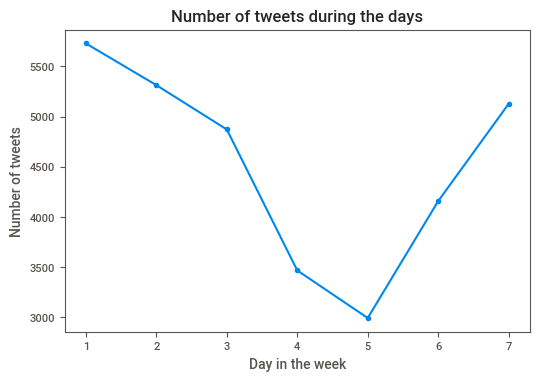

In [39]:
# x axis values for the days in the week
x = [1,2,3,4,5,6,7] 
# corresponding y axis values 
num_collected_tweets_per_day= [len(tweets_per_day) for tweets_per_day in tweets_per_day_list] 
y = num_collected_tweets_per_day
plt.plot(x, y,marker='o') 
plt.xlabel('Day in the week') 
plt.ylabel('Number of tweets') 
plt.title('Number of tweets during the days')
plt.show() 

Calculate the ratio of tweets with a positive sentiment per day:

In [56]:
#positive ratio tweets per day
positive_ratio_per_day= [len(day.loc[day["SVM predictions"] == 1])/ len(day) for day in tweets_per_day_list] 
positive_ratio_per_day= [(idx, item) for idx,item in enumerate(positive_ratio_per_day, start=1)]
positive_ratio_per_day

[(1, 0.5119608870263663),
 (2, 0.5267319277108434),
 (3, 0.5091357010880723),
 (4, 0.49653979238754326),
 (5, 0.5268781302170283),
 (6, 0.5086580086580087),
 (7, 0.49219664455715956)]

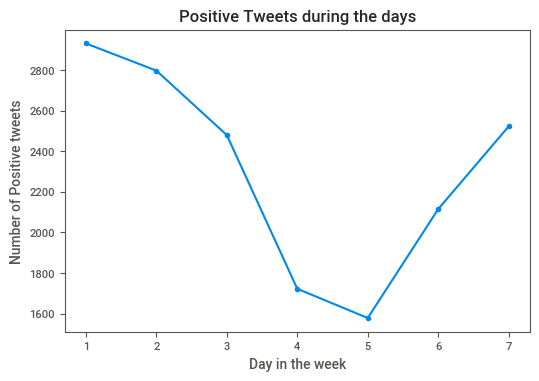

In [57]:
# corresponding y axis values 
num_collected_positive_tweets_per_day=[len(day.loc[day["SVM predictions"] == 1]) for day in tweets_per_day_list] 
y = num_collected_positive_tweets_per_day
plt.plot(x, y,marker='o') 
plt.xlabel('Day in the week') 
plt.ylabel('Number of Positive tweets') 
plt.title('Positive Tweets during the days')
plt.show() 

In [42]:
google_trend = pd.read_csv('/content/drive/MyDrive/multiTimeline.csv',header=None)
google_trend.columns = ['percentage_of_searches','day']

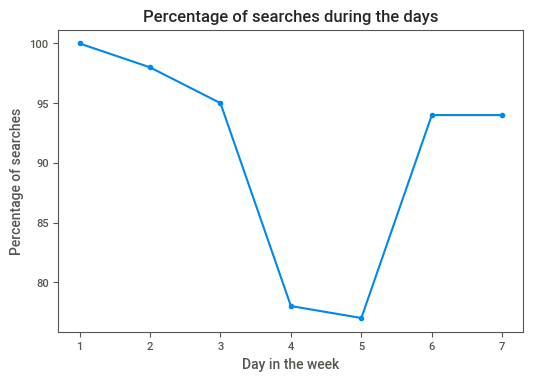

In [43]:
y=google_trend['percentage_of_searches']
x = [1,2,3,4,5,6,7]
plt.plot(x, y,marker='o') 
plt.xlabel('Day in the week') 
plt.ylabel('Percentage of searches') 
plt.title('Percentage of searches during the days')
plt.show()

In [58]:
#create df that the column are a,b,c questions
abc_data=pd.DataFrame()
abc_data['percentage_collected_tweets_per_day']=[100*(row)/max(num_collected_tweets_per_day) for row in num_collected_tweets_per_day] 
abc_data['percentage_positive_tweets_per_day']=[100*(row)/max(num_collected_positive_tweets_per_day) for row in num_collected_positive_tweets_per_day] 
abc_data['percentage_of_searches_per_day']=google_trend['percentage_of_searches']

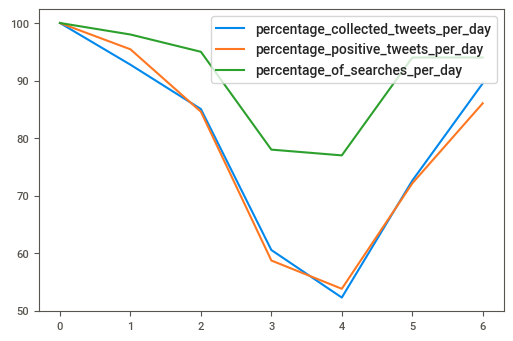

In [59]:
abc_data.plot( kind="line")

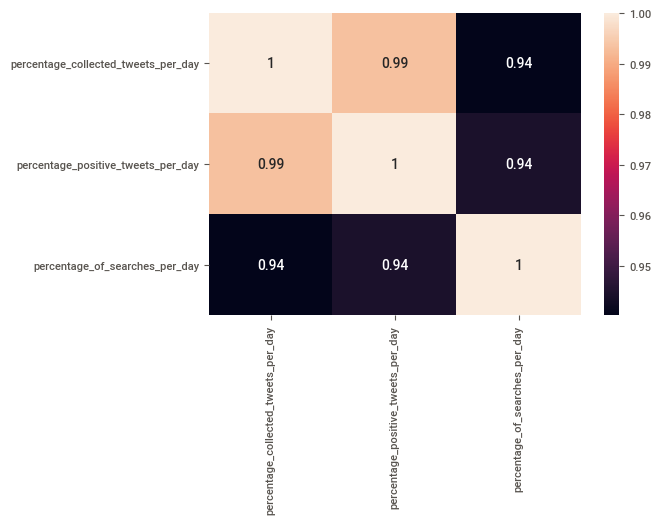

In [60]:
import seaborn as sn

corrMatrix = abc_data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()